<a href="https://colab.research.google.com/github/injoon-pij/pytorch-learning/blob/master/pytorch_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) One-hot Encoding

단어 집합의 크기를 벡터의 차원으로 하고, 표현하고 싶은 단어의 인덱스에 1을 부여하고, 다른 인덱스에는 0을 부여하는 단어의 벡터 표현 방식

그리고 이렇게 표현된 벡터를 원-핫 벡터(One-hot vector)라고 함

[원-핫 인코딩 과정]

1. 각 단어에 고유한 인덱스를 부여합니다. (정수 인코딩)
2. 표현하고 싶은 단어의 인덱스의 위치에 1을 부여하고, 다른 단어의 인덱스의 위치에는 0을 부여합니다

* 한국어 예제

In [ ]:
pip install konlpy

In [ ]:
from konlpy.tag import Okt  
okt = Okt()  
token = okt.morphs("나는 자연어 처리를 배운다")  # Okt 형태소 분석기를 통해 토큰화를 수행
print(token)

['나', '는', '자연어', '처리', '를', '배운다']


In [ ]:
# 각 토큰에 대해서 고유한 index 부여
word2index = {}
for voca in token:
     if voca not in word2index.keys():
       word2index[voca] = len(word2index)
print(word2index)

{'나': 0, '는': 1, '자연어': 2, '처리': 3, '를': 4, '배운다': 5}


In [ ]:
# one-hot vector 만드는 함수 정의
def one_hot_encoding(word, word2index):
       one_hot_vector = [0]*(len(word2index))
       index = word2index[word]
       one_hot_vector[index] = 1
       return one_hot_vector

one_hot_encoding("자연어",word2index)

[0, 0, 1, 0, 0, 0]

__[원-핫 인코딩 방식의 한계]__

1. 원-핫 인코딩 방식은 단어의 개수가 늘어날 수록, __벡터를 저장하기 위해 필요한 벡터의 차원이 계속 늘어남__. 원 핫 벡터는 단어 집합의 크기가 곧 벡터의 차원 수가 됨. 가령, 단어가 1,000개인 코퍼스를 가지고 원 핫 벡터를 만들면, 모든 단어 각각은 모두 1,000개의 차원을 가진 벡터가 되는데 이는 곧 __모든 단어들은 하나의 값만 1을 가지고, 999개의 값은 0의 값을 가지는 벡터가 되어 저장 공간 측면에서 매우 비효율적이게 됨.__

2. __원-핫 벡터는 단어 간 유사도를 표현하지 못함.__ 예를 들어서 늑대, 호랑이, 강아지, 고양이라는 4개의 단어에 대해서 원-핫 인코딩을 해서 각각, [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]이라는 원-핫 벡터를 부여받았다고 할 때, __원-핫 벡터로는 강아지와 늑대가 유사하고, 호랑이와 고양이가 유사하다는 것을 표현할 수가 없음.__ 좀 더 극단적으로는 강아지, 개, 냉장고라는 단어가 있을 때 강아지라는 단어가 개와 냉장고라는 단어 중 어떤 단어와 더 유사한지도 알 수 없음.

# 2) Word2Vec

## 2.1 Word Embedding

단어를 __밀집 벡터(dense vector)의 형태__로 표현하는 방법을 워드 임베딩(word embedding)이라고 함. 그리고 이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 __임베딩 벡터(embedding vector)__라고도 함.

워드 임베딩 방법론으로는 LSA, Word2Vec, FastText, Glove 등이 있음. 파이토치에서 제공하는 도구인 nn.embedding()는 앞서 언급한 방법들을 사용하지는 않지만, 단어를 랜덤한 값을 가지는 밀집 벡터로 변환한 뒤에, 인공 신경망의 가중치를 학습하는 것과 같은 방식으로 단어 벡터를 학습하는 방법을 사용함.


| -	                   |원 핫 벡터      |임베딩 벡터             |
|:--------------------:|:--------------:|:----------------------:|
|차원(단어 집합의 크기)|고차원          |저차원                  |
|다른 표현             |희소 벡터의 일종|밀집 벡터의 일종        |
|표현 방법             |수동	          |훈련 데이터로부터 학습함|
|값의 타입             |1 과  0         |실수                    |

* 희소 벡터(Sparse Representation) : 벡터 또는 행렬(matrix)의 값이 대부분이 0으로 표현되는 방법
 * 문제점
   * 단어의 개수가 늘어나면 벡터의 차원이 한없이 커져 공간적 낭비 발생
   * 단어 벡터 간 유사도를 표현할 수 없음
 * EX) 강아지 = [ 0 0 0 0 1 0 0 0 0 0 0 0 ... 0] # 벡터의 차원은 10,000
* 밀집 벡터(Dense Representation) : 벡터의 차원을 단어 집합의 크기로 상정하지 않고 사용자가 설정한 값으로 모든 단어의 벡터 표현의 차원을 맞추는 방법
 * 0과 1만 가진 값이 아니라 실수값을 가짐
 * EX) 강아지 = [0.2 1.8 1.1 -2.1 1.1 2.8 ...] # 이 벡터의 차원은 128(= 사용자 지정값)

## 2.2 Word2Vec

단어 간 유사도를 반영할 수 있도록 __단어의 의미를 벡터화__하기 위해 사용되는 대표적인 방법

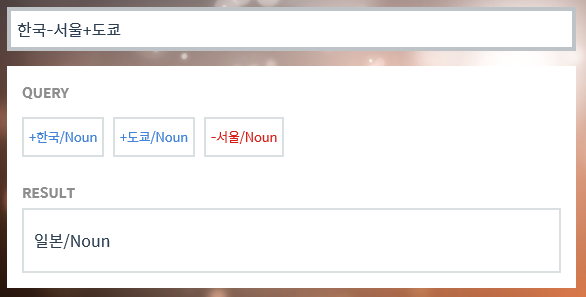

희소 표현 방법은 각 단어간 유사성을 표현할 수 없다는 단점이 있었고, 이를 위한 대안으로 단어의 '의미'를 다차원 공간에 벡터화하는 방법을 찾게되는데, 이러한 표현 방법을 __분산 표현(distributed representation)이라고 함__

* __분산표현__ : 분포 가설(distributional hypothesis)이라는 가정 하에 만들어진 표현 방법. 이때 분포 가설이란 __"비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다"__ 또는 __"단어의 의미는 주변 단어에 의해 형성된다"__는 가설.

분산 표현은 저차원에 단어의 의미를 여러 차원에다가 분산하여 표현하고, 이런 표현 방법을 사용하면 단어 간 유사도를 계산할 수 있음. 분산 표현을 이용하여 단어의 유사도를 벡터화하는 작업은 워드 임베딩(embedding) 작업에 속하기 때문에 이렇게 표현된 벡터 또한 임베딩 벡터(embedding vector)라고 하며, 저차원을 가지므로 바로 앞의 챕터에서 배운 밀집 벡터(dense vector)에도 속함.

### 2.2.1 CBOW(Continuous Bag of Words)

* CBOW : 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 Word2Vec 모델 종류

__"The fat cat sat on the mat"__

다음과 같은 문장이 있다고 할 때, {"The", "fat", "cat", "on", "the", "mat"}으로부터 "sat"을 예측하는 것이 위 그림에 나온 CBOW의 예측 방식

* 중심단어(center word) : 예측해야하는 단어 
* 주변단어(context word) : 예측에 사용되는 단어
* 윈도우(window) :  중심 단어를 예측하기 위해서 앞뒤로 볼 주변단어의 범위
* 슬라이딩 윈도우(sliding window) : 윈도우를 계속 움직이며 주변 단어와 중심 단어 선택을 바꿔가며 학습을 위한 데이터 셋을 만드는 방법

아래 그림은 윈도우 크기가 2일때, 슬라이딩 윈도우가 어떤 식으로 이루어지면서 데이터 셋을 만드는지 보여줌

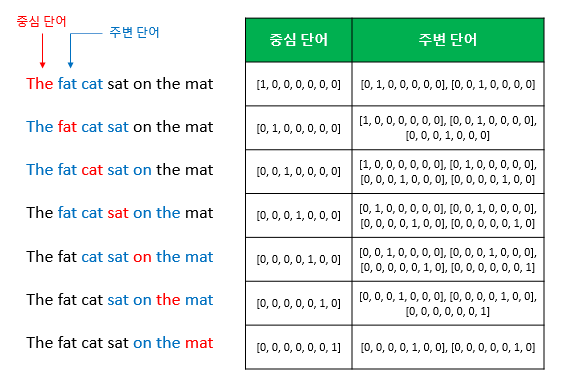

---

__[CBOW 모델 도식화]__

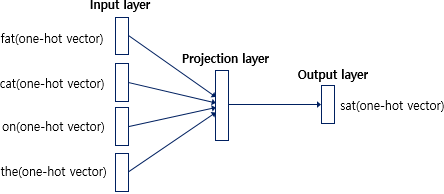

* 입력층의 입력으로는 사용자가 정한 윈도우 크기 범위 안에 있는 주변 단어들의 원-핫 벡터가 들어가게 되고, 훈련을 위해서는 출력층에서 예측하고자 하는 중심 단어의 원-핫 벡터가 필요함.
* Word2Vec은 딥러닝 모델(Deep Learning Model)은 아님. 보통 딥러닝 모델이라하면, 입력층-출력층 사이의 은닉층의 개수가 충분히 쌓인 신경망 모델을 말하는데 Word2Vec는 입력층과 출력층 사이에 하나의 은닉층만이 존재함. 이렇게 은닉층이 1개인 경우에는 일반적으로 심층신경망(Deep Neural Network)이 아니라 __얕은신경망(Shallow Neural Network)__이라고 부름.
* Word2Vec의 은닉층은 일반적인 은닉층과는 달리 활성화 함수가 존재하지 않으며 __룩업 테이블(Lookup table)__이라는 연산을 담당하는 층으로 일반적인 은닉층과 구분하기 위해 __투사층(projection layer)__이라고 부르기도 함.
 * __Lookup table__ : 행렬의 i번째 행 또는 열을 그대로 읽어오는 연산 (후에 설명)

---

__[CBOW 모델의 메커니즘]__

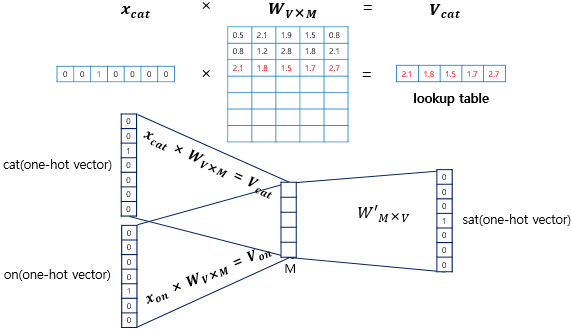

* 입력 벡터는 원-핫 벡터이므로, i번째 인덱스에 1이라는 값을 가지고 그 외의 0의 값을 가지는 입력 벡터와 가중치 $W_{V\text{×}M}$ 행렬의 곱은 사실 $W_{V\text{×}M}$행렬의 $i$번째 행을 그대로 읽어오는 것과 동일 (lookup table 연산)
* lookup해온 $W_{V\text{×}M}$행렬의 각각 행 벡터가 곧 모델의 학습을 통해 얻게 되는 $M$차원의 크기를 갖는 각 단어들의 임베딩 벡터가 됨. 즉, 투사층(Projection Layer)의 차원($M$)이 곧 각 단어들을 임베딩한 임베딩 벡터의 차원 크기가 됨
* 즉, CBOW 모델의 목적은 $W$와 $W'$를 잘 훈련시키는 것임 

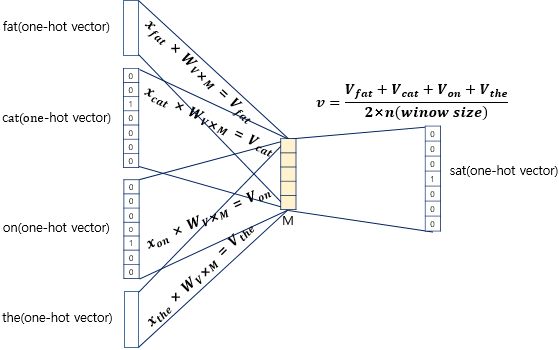

* 주변 단어의 원-핫 벡터에 대해서 가중치 $W_{V\text{×}M}$가 곱해서 생겨진 결과 벡터들은 투사층에서 만나고, 그리고 이 벡터들의 __평균 벡터__를 구함

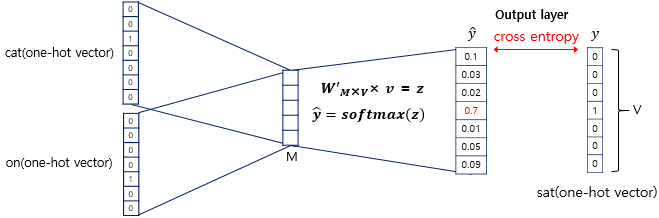

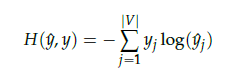

* 투사층을 통과한 평균 벡터는 두번째 가중치 행렬 $W'_{M\text{×}V}$와 곱해지고, 곱셈의 결과로 원-핫 벡터들과 차원이 $V$로 동일한 벡터가 나옴. 이 벡터에 소프트맥스 함수를 취하여 스코어 벡터(score vector)($\hat{y}_j$)를 구한 뒤, __정답 벡터를 중심단어의 원-핫 벡터__(${y}_j$)로 두고 __cross-entropy 함수를 손실함수__로 사용하여 오차를 계산함

### 2.2.2 Skip-Gram

* Skip-Gram : 중심에 있는 단어들을 가지고, 주변에 있는 단어들을 예측하는 Word2Vec 모델 종류

__[Skip-Gram 모델 도식화]__

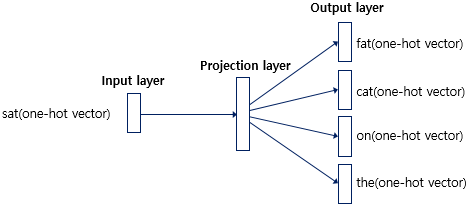

* 입력층의 입력으로는 중심단어의 원-핫 벡터가 들어가게 되고, 훈련을 위해서는 출력층에서 예측하고자 하는 사용자가 정한 윈도우 크기 범위 안에 있는 주변 단어들의 원-핫 벡터가 필요함.
* 출력층이 주변단어의 수만큼 존재하므로, __각각의 출력층에서 개별적으로 손실을 구하고 이 개별 손실을 모두 더한 값을 최종 오차를 계산함__
* 성능 비교를 진행했을 때, __전반적으로 Skip-gram이 CBOW보다 성능이 좋다고 알려져 있음.__ 이는 skip-gram 모델의 예측 난이도가 CBOW 모델의 예측 난이도보다 더 어렵기 때문에 훈련을 통해 나온 단어들의 분산 표현이 좀 더 뛰어날 가능성이 높기 때문
* __말뭉치가 커질수록 저빈도 단어나 유추 문제의 성능 면에서 skip-gram 모델이 더 뛰어남__. 반면 skip-gram 모델은 주변 단어들의 수만큼 손실을 계산해야 하므로 __학습 속도 면에서는 CBOW 모델이 더 뛰어남__

### 2.2.3 Negative Sampling

출력층에서 __모든 단어 집합에 대해 softmax 함수를 취하는 다중 분류 문제__를, 예측해야 하는 단어를 긍정(positive)으로, 예측 단어와 관련없는 단어를 랜덤으로 샘플링하여 부정(negetive)으로 두어 __이진 분류 문제__로 전환하는 방법.
* Word2Vec이 출력층에서 모든 단어 집합에 대해서 소프트맥스 함수를 수행하고 역전파를 수행하므로 주변 단어와 상관 없는 모든 단어까지의 워드 임베딩 조정 작업을 수행하게 되어 연산량이 불필요하게 증가해 학습 속도가 저하됨
* 이에 전체 단어 집합에 대한 다중 분류문제가 아닌, 일부 주변 단어 집합(positive)과 랜덤으로 샘플링한 관련없는 단어 집합(negative) 간의 이중 분류문제로 전환하여 계산하는 아이디어
* 결국 출력층에서 positive 집합에 속하는 단어들과의 이중 분류함수의 손실함수 값과 negative 집합에 속하는 단어들과의 이중 분류함수의 손실함수 값을 더한 값이 최종 손실값이 됨
* 대체적으로 Word2Vec를 사용한다고 하면 SGNS(Skip-Gram with Negative Sampling)을 사용

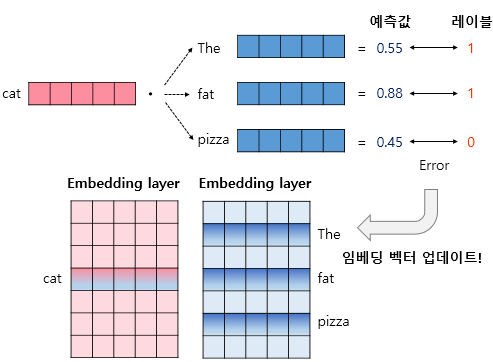

# 3) Training Word2Vec model

## 3.1 English model

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

### 3.1.1 Data Download

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7fb6bce78310>)

아래는 xml 파일의 형식이다. 실질적인 자연어 데이터를 얻기 위해서는 전처리를 통해 xml 문법들은 제거하고 영어문장으로만 구성된 내용을 담고 있는 \<content>와 \</content> 사이의 내용을 가져와야 한다. 뿐만 아니라, \<content>와 \</content> 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거해야 한다.

```xml
<file id="1">
  <head>
<url>http://www.ted.com/talks/knut_haanaes_two_reasons_companies_fail_and_how_to_avoid_them</url>
       <pagesize>72832</pagesize>
... xml 문법 중략 ...
<content>
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities:
... content 내용 중략 ...
To me, the irony about the Facit story is hearing about the Facit engineers, who had bought cheap, small electronic calculators in Japan that they used to double-check their calculators.
(Laughter)
... content 내용 중략 ...
(Applause)
</content>
</file>
<file id="2">
    <head>
<url>http://www.ted.com/talks/lisa_nip_how_humans_could_evolve_to_survive_in_space<url>
... 이하 중략 ...
```



### 3.1.2 Data preprocessing

In [ ]:
# file open
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8') 
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = []
result = [word_tokenize(sentence) for sentence in normalized_text]

In [ ]:
print('총 샘플의 개수 : {}'.format(len(result)))

for line in result[:3]:
    print(line)

총 샘플의 개수 : 273424
['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


---

\+ Parse란?

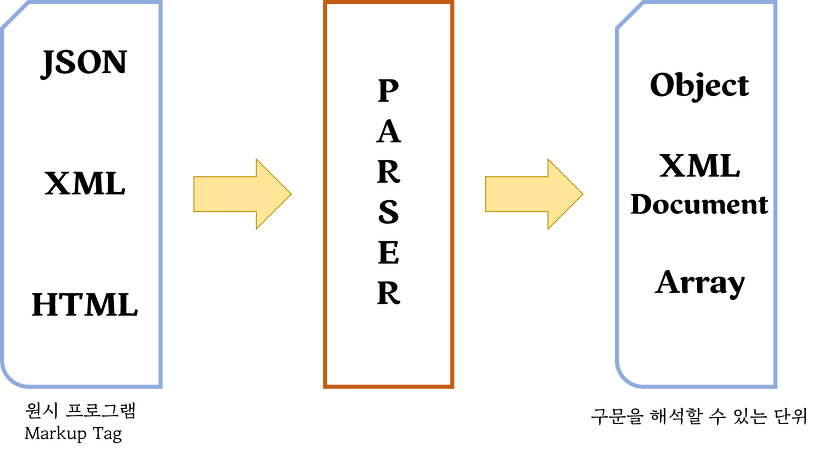

---

### 3.1.3 Train Word2Vec model

In [ ]:
from gensim.models import Word2Vec, KeyedVectors
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

* sentences = 각 문장이 단어 토큰으로 이뤄진 데이터 형식
* size = 임베딩 된 단어벡터의 차원.
* window = 윈도우 크기
* min_count = 단어 최소 빈도 수 제한
* workers = 학습을 위한 프로세스 수
* sg = 0은 CBOW, sg = 1은 Skip-gram.

In [ ]:
# 입력한 단어에 대해서 가장 유사한 단어들을 출력
model.wv.most_similar("man")

[('woman', 0.8586868047714233),
 ('guy', 0.81027752161026),
 ('boy', 0.7769557237625122),
 ('girl', 0.772038996219635),
 ('lady', 0.770781934261322),
 ('gentleman', 0.7454910278320312),
 ('soldier', 0.7442405223846436),
 ('kid', 0.7234257459640503),
 ('poet', 0.689899742603302),
 ('rabbi', 0.6764054894447327)]

### 3.1.4 Save trained model and Load

In [ ]:
model.wv.save_word2vec_format('./eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [ ]:
print(loaded_model.vectors.shape) # 모델의 크기 확인

(21613, 100)


## 3.2 Korean model

### 3.2.1 Data Download

In [ ]:
import urllib.request

In [ ]:
# 위키피디아 한국어 덤프 파일 다운로드
urllib.request.urlretrieve("https://dumps.wikimedia.org/kowiki/latest/kowiki-latest-pages-articles.xml.bz2", filename="kowiki-latest-pages-articles.xml.bz2")

('kowiki-latest-pages-articles.xml.bz2',
 <http.client.HTTPMessage at 0x7fe138c84e10>)

In [ ]:
# 위키피디아 덤프 파일을 텍스트 형식으로 변환시켜주는 오픈소스인 '위키피디아 익스트랙터' 다운로드
!git clone "https://github.com/attardi/wikiextractor.git" 

Cloning into 'wikiextractor'...
remote: Enumerating objects: 742, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 742 (delta 0), reused 0 (delta 0), pack-reused 741
Receiving objects: 100% (742/742), 1.28 MiB | 6.24 MiB/s, done.
Resolving deltas: 100% (433/433), done.


In [ ]:
# setup.py 실행
# cd wikiextractor/
# !python setup.py install

In [ ]:
# 위키피디아 한국어 덤프 파일을 텍스트 형식으로 변환
# 위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 동일한 디렉토리 경로에 두고, 해당 경로에서 아래 명령어를 실행
# -m mod : run library module as a script
!python -m wikiextractor.WikiExtractor kowiki-latest-pages-articles.xml.bz2

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 9개의 디렉토리(2021년 8월 기준)로 구성되어져 있다. AA ~ AI 디렉토리로 각 디렉토리 내에는 wiki_00 ~ wiki_99이라는 파일들이 들어있다. 각 파일들을 열어보면 이와 같은 구성이 반복되고 있다.

```xml
<doc id="문서 번호" url="실제 위키피디아 문서 주소" title="문서 제목">
내용
</doc>
```



예를 들어서 AA 디렉토리의 wiki_00 파일의 내부는 다음과 같다

```xml
<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">
지미 카터
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령(1977년 ~ 1981년)이다.
지미 카터는 조지아 주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대
위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다.
... 이하 중략...
</doc>
```

이제 이 9개 AA ~ AI 디렉토리 안의 wiki00 ~ wiki99 파일들을 워드 임베딩 모델의 입력으로 사용하기 위해 하나의 텍스트 파일로 통합한다

```
# window 환경 기준
copy AA디렉토리의 경로\wiki* wikiAA.txt  # 504294 lines
copy AB디렉토리의 경로\wiki* wikiAB.txt  # 663099 lines
copy AC디렉토리의 경로\wiki* wikiAC.txt  # 783083 lines
copy AD디렉토리의 경로\wiki* wikiAD.txt  # 989945 lines
copy AE디렉토리의 경로\wiki* wikiAE.txt  # 1197140 lines
copy AF디렉토리의 경로\wiki* wikiAF.txt  # 1324143 lines
copy AG디렉토리의 경로\wiki* wikiAG.txt  # 1604183 lines
copy AH디렉토리의 경로\wiki* wikiAH.txt  # 1940305 lines
copy AI디렉토리의 경로\wiki* wikiAI.txt  # 596135 lines

copy 현재 디렉토리의 경로\wikiA* wiki_data.txt  # 9602327 lines
```

In [ ]:
# wiki_data : 모든 텍스트 파일을 하나로 만든 훈련 데이터
f = open('/content/wiki_data.txt', encoding="utf8")

In [ ]:
# 파일이 정상적으로 저장되었는지 5개의 줄만 출력
i=0
while True:
    line = f.readline()
    if line != '\n':
        i=i+1
        print("%d번째 줄 :"%i + line)
    if i==10:
        break 
f.close()

1번째 줄 :<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2번째 줄 :지미 카터

3번째 줄 :제임스 얼 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.

4번째 줄 :생애.

5번째 줄 :어린 시절.

6번째 줄 :지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 

7번째 줄 :조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

8번째 줄 :정계 입문.

9번째 줄 :1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주지사 선거에 낙선하지만, 1970년 조지아 주지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.

10번째 줄 :대통령 재임.



### 3.2.2 Data preprocessing

* 명사만을 추출하여 훈련 데이터를 구성
* wiki_data의 용량이 너무 커서 전처리가 너무 오래 걸려 wikiAA만 학습 데이터로 사용

In [ ]:
pip install konlpy

In [ ]:
from konlpy.tag import Okt  
okt=Okt()
fread = open('/content/wikiAA.txt', encoding="utf8") # 실행시간 : 1시간 20분
# 파일을 다시 처음부터 읽음.
n = 0
result = []

while True:
    line = fread.readline() # 한 줄씩 읽음.
    if not line: break # 모두 읽으면 while문 종료.
    n = n + 1
    if n % 10000 == 0: # 10,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 While문."%n)
    if len(line.split()) == 0: continue # '\n' 라인 제외
    if line.split()[0] == '<doc' or line.split()[0] == '</doc>': continue # 텍스트 데이터가 아닌 line 제외

    result.append(okt.nouns(line))

fread.close()

In [ ]:
print('총 샘플의 개수 : {}'.format(len(result))) # 35만개

총 샘플의 개수 : 358298


### 3.2.3 Train Word2Vec model

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)

In [ ]:
model.wv.most_similar("대한민국")

[('한국', 0.657278835773468),
 ('조선민주주의인민공화국', 0.6167443990707397),
 ('북한', 0.5751476883888245),
 ('우리나라', 0.5356243848800659),
 ('중화인민공화국', 0.5323051810264587),
 ('중화민국', 0.5188068747520447),
 ('일본국', 0.4998365342617035),
 ('정보통신부', 0.4865521788597107),
 ('중진국', 0.47862330079078674),
 ('탈북자', 0.4730304181575775)]

In [ ]:
model.wv.most_similar("반도체")

[('전자제품', 0.8403751850128174),
 ('바이오', 0.8069779872894287),
 ('다이오드', 0.8019563555717468),
 ('부도체', 0.7952368259429932),
 ('부품', 0.7938951253890991),
 ('전자기기', 0.7932538986206055),
 ('나노', 0.7931122779846191),
 ('실리콘', 0.7848839163780212),
 ('가전', 0.7833805084228516),
 ('트랜지스터', 0.7830585837364197)]

In [ ]:
model.wv.most_similar("강아지")

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [ ]:
model.wv.most_similar("스마트폰")

[('휴대폰', 0.9324889183044434),
 ('모바일', 0.9254841804504395),
 ('휴대전화', 0.9088627099990845),
 ('노트북', 0.9063665270805359),
 ('안드로이드', 0.9003423452377319),
 ('아이폰', 0.8948783874511719),
 ('상용', 0.8892204165458679),
 ('디스플레이', 0.8891453742980957),
 ('오피스', 0.8838678598403931),
 ('단말기', 0.8821154236793518)]

### 3.2.4 Save trained model and Load

In [ ]:
model.wv.save_word2vec_format('./wikiAA_kor_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("wikiAA_kor_w2v") # 모델 로드

In [ ]:
print(loaded_model.vectors.shape) # 모델의 크기 확인

(56600, 100)


## 3.3 Pre-trained Word2Vec model

자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용할 수도 있음

여기서는 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습만 진행. 실제로 모델에 적용해보는 실습은 7)에서 진행.

### 3.3.1 English

* 구글이 제공하는 사전 훈련 Word2Vec 모델
  * 사전 훈련된 3백만 개의 Word2Vec 단어 벡터 제공 
  * 각 임베딩 벡터의 차원은 300
  * gensim을 통해 model load 가능.
  * 압축 파일의 용량은 약 1.5GB이지만, 압축을 풀면 약 3.3GB.

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

리눅스 명령어 wget을 통해 다운받을 수도 있다

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-08-23 15:43:53--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  79.0MB/s    in 20s     

2021-08-23 15:44:14 (77.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
from gensim.models import KeyedVectors

# 3백만 개 단어를 모두 가져오면 시간이 오래 걸리고 메모리를 많이 차지하므로 3만 개만 사용

# 직접 파일을 디렉토리에 다운로드하여 압축을 풀어 저장한 경우
# model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin 파일 경로', binary=True, limit=30000)

model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True, limit=30000)

In [ ]:
print(model.vectors.shape) # 모델의 크기 확인
print(model.vector_size) # 임베딩 벡터의 크기 확인

(30000, 300)
300


In [ ]:
# 두 단어의 유사도 계산하기
print(model.similarity('this', 'is'))
print(model.similarity('post', 'book'))
print(model.most_similar("book"))

0.40797037
0.057204384
[('books', 0.7379178404808044), ('memoir', 0.7302927374839783), ('autobiography', 0.6741527915000916), ('memoirs', 0.6505153179168701), ('Book', 0.6479282379150391), ('novels', 0.6341458559036255), ('cookbook', 0.6180881261825562), ('biography', 0.6155841946601868), ('novel', 0.6121935844421387), ('Books', 0.5862935781478882)]


(메서드 사용 시 주의사항)
* gensim.Word2Vec으로 모델을 load한 경우 : model.__wv__.(메서드)
* gensim.KeyedVecors로 모델을 load한 경우 : model.(메서드)

### 3.3.2 Korean

한국어의 미리 학습된 Word2Vec 모델은 박규병님의 깃허브 주소인 https://github.com/Kyubyong/wordvectors 에 공개되어져 있음

모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec.load('/content/ko.bin')

In [ ]:
model.wv.most_similar("강아지")

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [ ]:
model.wv.most_similar("반도체")

[('트랜지스터', 0.7577071189880371),
 ('실리콘', 0.7235332131385803),
 ('다이오드', 0.7178866267204285),
 ('절연체', 0.712357759475708),
 ('박막', 0.6907628774642944),
 ('진공관', 0.6894094944000244),
 ('폴리머', 0.680312991142273),
 ('축전기', 0.6753451824188232),
 ('집적', 0.6688355803489685),
 ('산업용', 0.6627157330513)]

# 4) Embedding Visualization

In [ ]:
# 임베딩 벡터 시각화를 위해 사용할 파일 생성
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2021-08-22 07:40:27,778 - word2vec2tensor - INFO - running /usr/local/lib/python3.7/dist-packages/gensim/scripts/word2vec2tensor.py --input eng_w2v --output eng_w2v
2021-08-22 07:40:27,778 - utils_any2vec - INFO - loading projection weights from eng_w2v
2021-08-22 07:40:29,990 - utils_any2vec - INFO - loaded (21613, 100) matrix from eng_w2v
2021-08-22 07:40:31,835 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2021-08-22 07:40:31,835 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2021-08-22 07:40:31,838 - word2vec2tensor - INFO - finished running word2vec2tensor.py


* 기존에 있던 word embedding model eng_w2v 외에 eng_w2v_metadata.tsv와 eng_w2v_tensor.tsv 두 개의 파일을 생성

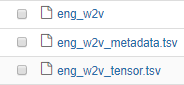

구글의 임베딩 프로젝터를 사용해서 워드 임베딩 모델을 시각화

링크 : https://projector.tensorflow.org

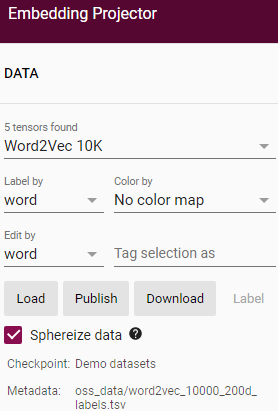

* Load 버튼 선택

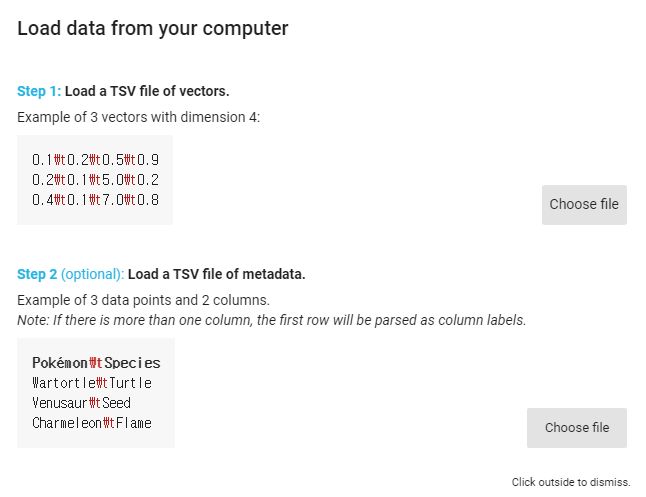

* eng_w2v_tensor.tsv를 위쪽 부분에 업로드, eng_w2v_metadata.tsv 아래쪽 부분에 업로드

# 5) GloVe

## 5.1 GloVe

### 5.1.1 Why GloVe?

* 기존 워드 임베딩 방법론
 * LSA : 각 단어의 빈도수를 카운트 한 행렬이라는 전체적인 통계 정보를 입력으로 받아 차원을 축소(Truncated SVD)하여 잠재된 의미를 끌어내는 방법론
 * Word2Vec : 실제값과 예측값에 대한 오차를 손실 함수를 통해 줄여나가며 학습하는 예측 기반의 방법론

* 기존 방법론의 한계점
 * LSA : 카운트 기반으로 코퍼스의 전체적인 통계 정보를 고려하기는 하지만, 왕:남자 = 여왕:? (정답은 여자)와 같은 단어 의미의 유추 작업(Analogy task)에는 성능이 떨어짐.
 * Word2Vec : 예측 기반으로 단어 간 유추 작업에는 LSA보다 뛰어나지만, 임베딩 벡터가 윈도우 크기 내에서만 주변 단어를 고려하기 때문에 코퍼스의 전체적인 통계 정보를 반영하지 못함 
 
* GloVe : 기존 방법론들의 각각의 한계를 보완하기 위해, LSA의 메커니즘이었던 카운트 기반의 방법과 Word2Vec의 메커니즘이었던 예측 기반의 방법론 두 가지를 모두 사용하는 방법론

### 5.1.2 Modeling

#### Co-occurence matrix/probability

__[Co-occurence matrix] (윈도우 기반 동시 등장 행렬)__

* I like deep learning
* I like NLP
* I enjoy flying

동시등장행렬 : 윈도우 크기가 N일 때, 특정 단어 __i__ 의 좌우에 존재하는 N개의 단어만 참고하여 단어 __k__ 가 등장한 횟수를 __i__ 행 __k__ 열에 기재한 행렬

아래는 윈도우 크기가 1일 때, 상위의 텍스트를 가지고 구성한 동시 등장 행렬

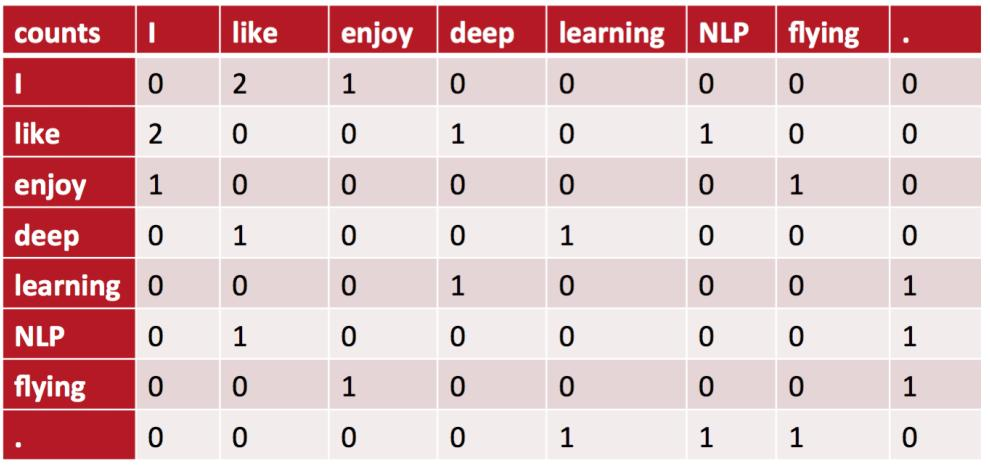

__[Co-occurence probability] (동시 등장 확률)__

$P(k\ |\ i)$ : 동시등장행렬로부터 특정 단어 __i__ 의 전체 등장 횟수를 카운트하고, __i__가 등장했을 때 어떤 단어 __k__ 가 등장한 횟수를 카운트하여 계산한 조건부 확률

아래의 표는 GloVe의 제안 논문에서 가져온 동시 등장 확률을 표로 정리한 것

|동시 등장 확률과 크기 관계 비 (ratio)|k = solid|k = gas |k = water|k = fasion|
|-------------------------------------|---------|--------|---------|----------|
|P(k l ice)                           |0.00019  |0.000066|0.003    |0.000017  |
|P(k l steam)                         |0.000022 |0.00078 |0.0022   |0.000018  |
|P(k l ice) / P(k l steam)            |8.9      |0.085   |1.36     |0.96      |

* $P(\text{solid} \text{ |} \text{ ice})$은 $P(\text{solid} \text{ |} \text{ steam})$ 보다 약 8.9배 큼
 * solid는 '단단한'이라는 의미이므로 steam보다는 ice라는 단어와 더 자주 등장할 것이기 때문
 * 즉 동시등장확률을 통해 단어 간 관계를 나타낼 수 있다

#### Loss function

동시등장행렬 및 동시등장확률을 바탕으로(통계적 방법론) 손실함수를 설계함

* $X$ : 동시 등장 행렬(Co-occurrence Matrix)
* $X_{ij}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 j가 등장하는 횟수
* $X_{i}$ = $\sum_j X_{ij}$ : 동시 등장 행렬에서 i행의 값을 모두 더한 값
* $P_{ik}$ = $P(k\ |\ i)$ = $\frac{X_{ik}}{X_{i}}$ : 중심 단어 i가 등장했을 때 윈도우 내 주변 단어 k가 등장할 확률
 * Ex) $P(\text{solid} \text{ |} \text{ ice})$ = 단어 ice가 등장했을 때 단어 solid가 등장할 확률
* $\frac{P_{ik}}{P_{jk}}$ : ${P_{ik}}$ 를 ${P_{jk}}$ 로 나눠준 값
 * Ex) $P(\text{solid} \text{ |} \text{ ice})$ / $P(\text{solid} \text{ |} \text{ steam})$ = 8.9
* $w_{i}$ : 중심 단어 i의 임베딩 벡터
* $\tilde{w_{k}}$ : 주변 단어 k의 임베딩 벡터

GloVe의 기본 아이디어는 __"임베딩 된 중심 단어 벡터와 주변 단어 벡터의 내적이 전체 코퍼스에서의 두 단어의 동시 등장 확률(의 log 값)이 되도록 만드는 것"__이다.

$dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ log\ P(k\ |\ i) = log\ P_{ik}$

1. $w_{i}, w_{j}, \tilde{w_{k}}$ 를 변수로 가지는 어떤 함수 $F$ 를 수행하면 $P_{ik} / P_{jk}$ 가 나온다고 가정
 * 동시등장확률값 관계비율 $P_{ik} / P_{jk}$ 를 이용하면 단어 간 관계를 잘 설명할 수 있을 것이라고 기대하기 때문
 * 따라서 함수 $F$ 는 각 단어 벡터들이 단어 간 동시등장확률값 관계비율 정보를 담도록 단어들을 벡터 공간에 인코딩하는 것이 목적임
 * 이에 GloVe 연구진들은 단어 의미 관계를 잘 표현하기 위하여 두 벡터 $w_{i}$ 와 $w_{j}$ 간 차이를 함수 $F$ 의 입력으로 사용하는 것을 제안함

$$F(w_{i},\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$$

$$F(w_{i} -\ w_{j},\ \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$$

2. 함수 $F$ 가 지나치게 복잡해지는 것을 막기 위해 양변의 파라미터의 형태를 통일시킴
 * 좌변의 벡터값을 스칼라값으로 바꿔주기 위해 함수 $F$ 의 두 입력 파라미터에 내적(Dot product)을 수행함.
 * 정리하면, 선형 공간에서의 단어 간 의미 관계를 잘 표현하기 위해 함수의 파라미터를 선정하는 과정에서 벡터 간 뺄셈과 내적을 택함

$$F((w_{i} -\ w_{j})^{T} \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$$

3. 중심 단어 $w_{i}$ 와 주변 단어 $\tilde{w_{k}}$ 라는 선택 기준은 실제로는 무작위 선택이므로 이 둘의 관계는 자유롭게 교환될 수 있어야 함. 
 * 위 조건이 성립되기 위해, 함수 $F$ 가 실수의 덧셈과 양수의 곱셈에 대해서 준동형(Homomorphism)이라는 조건을 만족하도록 하였음.

$$F(a+b) = F(a)F(b),\ \forall a,\ b\in \mathbb{R}$$



4. 3번의 준동형식의 $a$, $b$ 를 두 벡터의 내적값이라고 하면 식이 다음과 같아짐

$$F(v_{1}^{T}v_{2} + v_{3}^{T}v_{4}) = F(v_{1}^{T}v_{2})F(v_{3}^{T}v_{4}),\ \forall v_{1},\ v_{2},\ v_{3},\ v_{4}\in V$$

5. GloVe model을 위한 식에서는 벡터 간 뺄셈이 나왔으므로 위의 준동형식을 뺄셈에 대한 준동형식으로 변경하면 다음과 같아짐

$$F(v_{1}^{T}v_{2} - v_{3}^{T}v_{4}) = \frac{F(v_{1}^{T}v_{2})}{F(v_{3}^{T}v_{4})},\ \forall v_{1},\ v_{2},\ v_{3},\ v_{4}\in V$$ 

6. 2번 식의 좌변을 풀어쓰면 $F(w_{i}^{T}\tilde{w_{k}}\ -\ w_{j}^{T}\tilde{w_{k}})$. 그리고 $F$ 가 5번의 조건을 만족하기 위해선 우변에서 $\frac{P_{ik}}{P_{jk}}$ = $\frac{F(w_{i}^{T}\tilde{w_{k}})}{F(w_{j}^{T}\tilde{w_{k}})}$ 가 성립되어야 함.

7. 이에 더하여 6번에서 구한 우변 항의 조건을 만족하려면 $F(w_{i}^{T}\tilde{w_{k}}) = P_{ik} = \frac{X_{ik}}{X_{i}}$ 도 성립해야함

8. 앞서 구한 조건들을 충족하는 함수 $F$ 는 __지수함수(Exponential function)__

 * 뺄셈에 대한 준동형식 조건 : $exp(w_{i}^{T}\tilde{w_{k}}\ -\ w_{j}^{T}\tilde{w_{k}}) = \frac{exp(w_{i}^{T}\tilde{w_{k}})}{exp(w_{j}^{T}\tilde{w_{k}})}$
 * 위의 준동형식 조건이 성립하기 위한 조건 : $exp(w_{i}^{T}\tilde{w_{k}}) = P_{ik} = \frac{X_{ik}}{X_{i}}$

9. 8번의 두번째 조건식으로부터 $w_{i}^{T}\tilde{w_{k}} = log\ P_{ik} = log\ (\frac{X_{ik}}{X_{i}}) = log\ X_{ik} - log\ X_{i}$ 라는 식을 도출할 수 있음
  * 정리하면 GloVe model을 위한 2번의 $F((w_{i} -\ w_{j})^{T} \tilde{w_{k}}) = \frac{P_{ik}}{P_{jk}}$ 을 푸는 것은 곧 $w_{i}^{T}\tilde{w_{k}} + log\ X_{i} = log\ X_{ik}$ 를 푸는 것과 동일함
  * 이는 앞서 언급한 GloVe model의 __기본 아이디어의 내용__과 같음 ( $dot\ product(w_{i}\ \tilde{w_{k}}) \approx\ log\ P(k\ |\ i) = log\ P_{ik}$ )

10. 중심 단어 $w_{i}$ 와 주변 단어 $\tilde{w_{k}}$ 는 자유롭게 교환될 수 있어야 함. 따라서 $log\ X_{ik}$ = $log\ X_{ki}$ 는 성립하나, $log\ X_{i}$ 는 교환이 성립되지 않음.
  * 이를 보완하기 위해 $log\ X_{i}$ 를 $w_{i}$ 에 대한 편향 $b_{i}$ 으로 대체. 같은 이유로 $\tilde{w_{k}}$ 에 대한 편향 $\tilde{b_{k}}$ 를 추가적으로 더해줌
  * 정리하면 $w_{i}^{T}\tilde{w_{k}} + b_{i} + \tilde{b_{k}} = log\ X_{ik}$

11. 따라서 GloVe 모델은 $w_{i}^{T}\tilde{w_{k}} + b_{i} + \tilde{b_{k}} = log\ X_{ik}$ 식에서 좌변값과 우변값 간의 차이를 최소화하는 방향으로 학습하는 임베딩 모델이 됨
  * __Loss function__ = $\sum_{m, n=1}^{V}\ (w_{m}^{T}\tilde{w_{n}} + b_{m} + \tilde{b_{n}} - logX_{mn})^{2}$

#### Loss function 개선

문제점 1 : $log\ X_{mn}$ 가 0이 되는 경우가 발생할 수도 있음
 * $log\ X_{mn}$ 를 $log\ (1 + X_{mn})$ 로 변경

문제점 2 : 동시등장행렬 $X$ 가 희소 행렬 (Sparse Matrix) 일 가능성이 높음
 * 동시 등장 행렬 $X$ 은 많은 값이 0이거나, 적은 값을 가지는데, GloVe의 연구진은 이 경우에 굉장히 낮은 동시등장 빈도값 $X_{ik}$ 는 임베딩 정보에 거의 도움이 되지 않는다고 판단하였음
 * $X_{ik}$ 의 값에 영향을 받는 가중치 함수 $f(X_{ik})$
를 손실 함수에 도입하는 것으로 보완

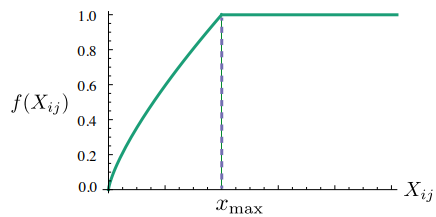

* 위의 가중치 함수의 값을 손실 함수에 곱해주면 가중치의 역할을 할 수 있음
 * $f(x) = min(1,\ (x/x_{max})^{3/4})$

* $X_{ik}$ 의 값이 작으면 상대적으로 가중치 함수의 값은 작도록 하고, 값이 크면 함수의 값은 상대적으로 크도록 함. 즉, 동시등장 빈도값이 클수록 포함하고 있는 더 큰 가중치를 더 부여함.

* 그러나 'It is' 와 같은 불용어의 동시 등장 빈도수가 높다고해서 지나친 가중을 받아서는 안됨. 이에 $X_{ik}$ 가 지나치게 높다고해서 지나친 가중치를 주지 않기위해 함수의 최대값이 정해놓음 (최대값은 1)

* 최종 손실함수 : $\sum_{m, n=1}^{V}\ f(X_{mn})(w_{m}^{T}\tilde{w_{n}} + b_{m} + \tilde{b_{n}} - logX_{mn})^{2}$

## 5.2 python package

In [1]:
!pip install glove_python-binary

훈련 데이터는 3.1에서 사용한 데이터를 가져와 사용한다

In [2]:
## 3.1

import nltk
nltk.download('punkt')
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", filename="ted_en-20160408.xml")

# file open
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8') 
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = []
result = [word_tokenize(sentence) for sentence in normalized_text]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from glove import Corpus, Glove

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus = Corpus() 
corpus.fit(result, window=5)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove = Glove(no_components=100, learning_rate=0.05) # no_components: number of latent dimensions
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True) # no_threads: number of training threads
glove.add_dictionary(corpus.dictionary) # Supply a word-id dictionary to allow similarity queries.

* corpus.fit : 훈련 데이터로부터 동시등장행렬(coo-matrix) 생성
 * result : 훈련 데이터. 각 문장이 토큰화된 단어로 이루어진 리스트 형태로 분리되어 있는 형태여야 함.
 * window : 동시등장행렬을 만들기 위한 window size

* glove.fit : 동시등장행렬을 가지고 단어들의 embedding vector 학습
 * corpus.matrix : (vocab_size x vocab_size) 사이즈인 단어들의 동시등장행렬 matrix
   * (0, 1)	247.29981994628906
   * (0, 1)	266.6165466308594
   * (0, 2)	43.26667785644531
   * (0, 2)	19.649999618530273
   * (0, 3)	2.25

* glove.add_dictionary : 벡터 유사도를 측정하기 위해 단어-인덱스 딕셔너리를 glove 객체에 제공
 * corpus.dictionary : corpus.matrix는 단어의 인덱스에 따른 동시등장행렬이므로 학습된 벡터의 인덱스 정보는 glove 객체에 주어졌지만, 그 인덱스가 어떤 단어인지는 아직 모름. 따라서 단어 벡터 유사도를 측정하기 위해서는 단어-인덱스 딕셔너리가 필요. 
   * {'here': 0, 'are': 1, 'two': 2, 'reasons': 3, 'companies': 4, ...

In [ ]:
glove.most_similar("man")

[('woman', 0.9576634986265438),
 ('guy', 0.8876035906939708),
 ('girl', 0.8601755647491339),
 ('young', 0.8314875142861373)]

In [ ]:
glove.most_similar("clean")

[('fresh', 0.836692539032301),
 ('water', 0.8287893135476887),
 ('wind', 0.8033893306136561),
 ('heat', 0.7975938215935184)]

# 6) nn.Embedding()

pytorch에서는 임베딩 벡터를 사용하는 방법이 크게 두 가지가 있다. 
* 임베딩 층(embedding layer)을 만들어 훈련 데이터로부터 처음부터 임베딩 벡터를 학습하는 방법
* 미리 사전에 훈련된 임베딩 벡터(pre-trained word embedding)들을 가져와 사용하는 방법

## 6.1 Embedding Layer by train data

임베딩 층이 무엇인지 먼저 알아보자

### 6.1.1 Embedding Layer/Embedding Vector

임베딩 층은 __입력 정수__에 대해 __밀집 벡터(dense vector)로 맵핑__하므로 임베딩 층의 입력으로 사용하기 위해서 __입력 시퀀스의 각 단어들은 모두 정수 인코딩이 되어있어야 함.__ 그리고 이 밀집 벡터는 인공 신경망의 학습 과정에서 가중치가 학습되는 것과 같은 방식으로 값이 업데이트되며 훈련되고 이러한 밀집 벡터를 __임베딩 벡터__라고 부름.

* 어떤 단어 → 단어에 부여된 고유한 정수값 → 임베딩 층 통과 → 밀집 벡터
 * (ex) 'great' -> 1918 -> 임베딩 층 통과 -> [1.2, 0.7, 1.9, 1.5]

* __"정수를 밀집 벡터 또는 임베딩 벡터로 맵핑한다"__
 * 특정 단어와 맵핑되는 정수를 인덱스로 가지는 테이블로부터 임베딩 벡터 값을 가져오는 룩업 테이블 연산을 뜻함. 그리고 이 테이블은 단어 집합의 크기만큼의 행을 가지므로 모든 단어는 고유한 임베딩 벡터를 가짐.

* 파이토치는 단어를 정수 인덱스로 바꾸고 원-핫 벡터로 한번 더 바꾸고나서 임베딩 층의 입력으로 사용하는 것이 아니라, __단어를 정수 인덱스로만 바꾼채로 임베딩 층의 입력으로 사용해도 룩업 테이블 연산된 결과인 임베딩 벡터를 리턴__

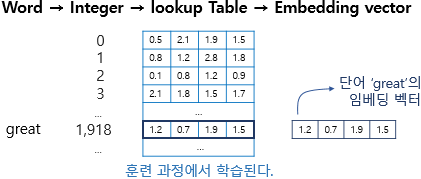

### 6.1.2 nn.Embedding()

* 위에서 언급한 룩업 테이블 연산 과정을 nn.Embedding()을 사용하여 구현
* 훈련 데이터로부터 처음부터 임베딩 벡터를 학습

In [ ]:
# 임의의 문장으로부터 단어 집합을 만들고 각 단어에 정수를 부여
train_data = 'you need to know how to code'
word_set = set(train_data.split()) # 중복을 제거한 단어들의 집합인 단어 집합 생성.
print("word set :", word_set)
vocab = {tkn: i+2 for i, tkn in enumerate(word_set)}  # 단어 집합의 각 단어에 고유한 정수 맵핑.
vocab['<unk>'] = 0
vocab['<pad>'] = 1
print("vocab :", vocab)

word set : {'code', 'how', 'know', 'you', 'to', 'need'}
vocab : {'code': 2, 'how': 3, 'know': 4, 'you': 5, 'to': 6, 'need': 7, '<unk>': 0, '<pad>': 1}


In [ ]:
import torch.nn as nn
embedding_layer = nn.Embedding(num_embeddings = len(vocab), 
                               embedding_dim = 3,
                               padding_idx = 1)

* num_embeddings : 임베딩을 할 단어들의 개수 (단어 집합의 크기)
* embedding_dim : 임베딩할 벡터의 차원
* padding_idx : 패딩을 위한 토큰의 인덱스

In [ ]:
# 테이블의 각 가중치들은 랜덤으로 초기화된 값 (학습 대상)
# 각 행은 단어 집합 내부 단어들의 고유한 밀집 벡터. 즉 단어 임베딩 벡터가 됨
print(embedding_layer.weight)
print(embedding_layer.weight.shape) # (vocab size, embedding_dim)

Parameter containing:
tensor([[ 0.2885,  0.2349, -0.3451],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.7617,  0.3869, -0.8428],
        [ 0.4375,  0.8276, -2.1060],
        [-0.5040,  0.6470, -0.0669],
        [-0.0927,  0.0406, -0.6748],
        [-0.3484, -0.0703, -1.2228],
        [-0.3273, -1.1207,  0.7492]], requires_grad=True)
torch.Size([8, 3])


## 6.2 Embedding Layer by Pretrained Word Embedding

임베딩 벡터를 얻기 위해서 위의 __6.1.2__에서처럼 nn.Embedding()을 통해 훈련 데이터로부터 처음부터 학습하는 경우도 있지만, 때로는 __이미 훈련되어져 있는 워드 임베딩을 불러서 이를 임베딩 벡터로 사용하는 경우__도 있다. 훈련 데이터가 부족한 상황이라면 다른 텍스트 데이터로 사전 훈련되어 있는 임베딩 벡터를 불러오는 것이 보다 더 나은 선택일 수 있는데 이는 __훈련 데이터가 적다면 파이토치의 nn.Embedding()으로 해당 문제에 충분히 특화된 임베딩 벡터를 만들어내는 것이 쉽지 않기 때문이다.__ 이 경우, 해당 문제에 특화된 것은 아니지만 보다 일반적이고 보다 많은 훈련 데이터로 이미 Word2Vec이나 GloVe 등으로 학습되어져 있는 임베딩 벡터들을 사용하는 것이 성능의 개선을 가져올 수 있다.

In [ ]:
from torchtext.legacy import data, datasets

# 필드 정의
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

# IMDB dataset을 다운로드하고, train set과 test set으로 분할
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:10<00:00, 7.78MB/s]


### 6.2.1 Pretrained Word Embedding ('eng_w2v' from 3.1)

In [ ]:
from gensim.models import KeyedVectors

# 사전에 훈련된 word2vec 임베딩모델 호출
word2vec_model = KeyedVectors.load_word2vec_format('eng_w2v')

# 영어 단어 'this'의 임베딩 벡터값 출력
print(word2vec_model['this'])

# 영어 단어 'self-indulgent'의 임베딩 벡터값 출력
# print(word2vec_model['self-indulgent'])
# KeyError: "word 'self-indulgent' not in vocabulary"

[ 2.1779501   0.4649845  -0.02115303 -1.5588403  -0.3704196  -0.23588836
 -1.9324682   0.03207028  1.4556663  -0.13391118  1.1935652   0.16076776
 -0.3592655  -0.89282036  0.21358773 -0.8031586   1.5218341  -1.2688942
  0.17041288 -0.7890596  -0.6156723  -0.18405679  0.5307449  -1.4867336
  1.1610315   1.1349376  -0.48443365 -1.6641445  -0.6093991   0.8671165
 -0.05253656  1.9087911   1.6567639  -1.6353478  -0.68040115 -0.1837007
  1.9857365  -0.21412064 -1.1443597  -0.11121586 -0.19582735  0.21274392
 -0.7304808   0.83506954 -1.339423   -0.8498765   1.6847974   0.09258489
  1.0611829  -0.9159705   1.325411   -0.6978549  -1.0708498  -2.49036
 -0.87933725  0.18590923  0.7410577  -2.1558945   1.8825114  -0.323948
 -1.4982564  -0.76048917 -0.9671853  -1.0750846   0.3810737  -0.9031111
  0.55739564 -2.090873   -0.06412065 -0.9735325  -0.4045709  -1.1377935
  0.6347887   0.93409824  0.47648332 -0.9398687  -0.42962334 -0.29436642
  1.5894254  -0.00673072 -0.5812945  -0.8036808  -1.0536957   

* 'self-indulgent'는 에러 발생. 이는 해당 단어가 Word2Vec 학습시에 존재하지 않았던 단어이므로 그에 대응되는 임베딩 벡터값이 없기 때문.

In [ ]:
import torch
import torch.nn as nn
from torchtext.vocab import Vectors

# 사전 훈련된 Word2Vec 모델을 vectors에 저장
vectors = Vectors(name="eng_w2v") 

# Field 객체의 build_vocab로 훈련 데이터의 단어 집합을 만드는 것과 동시에, 
# 사전에 훈련된 Word2Vec 모델에 저장되어져 있던 임베딩 벡터값들로 훈련 데이터의 임베딩 벡터값들을 초기화
TEXT.build_vocab(trainset, vectors=vectors, max_size=10000, min_freq=10)

100%|██████████| 21613/21613 [00:01<00:00, 21577.65it/s]


In [ ]:
# vocab 내부 살펴보기
print(TEXT.vocab.stoi)

In [ ]:
print('임베딩 벡터의 개수와 차원 : {} '.format(TEXT.vocab.vectors.shape))

임베딩 벡터의 개수와 차원 : torch.Size([10002, 100]) 


* 총 10,002개의 단어가 존재. (단, \<unk>와 \<pad>는 실제 단어가 아니라 특별 토큰이므로 실제 훈련 데이터의 단어는 10,000개) 
* 총 10,002개의 단어의 임베딩 벡터값들은 ```TEXT.vocab.vectors```에 저장되어져 있음
* 각 임베딩 벡터는 사전에 훈련된 모델에 저장되어져 있던 임베딩 벡터들과 같은 100차원  
* ```print(TEXT.vocab.stoi)```로 확인한 결과에서 각 단어의 고유한 정수 인덱스를 가지고, ```TEXT.vocab.vectors[인덱스]```를 통해서 각 단어의 임베딩 벡터값을 출력할 수 있음

In [ ]:
print(TEXT.vocab.vectors[0]) # <unk>의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [ ]:
print(TEXT.vocab.vectors[1]) # <pad>의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [ ]:
print(TEXT.vocab.vectors[10]) # this의 임베딩 벡터값

tensor([ 2.1780,  0.4650, -0.0212, -1.5588, -0.3704, -0.2359, -1.9325,  0.0321,
         1.4557, -0.1339,  1.1936,  0.1608, -0.3593, -0.8928,  0.2136, -0.8032,
         1.5218, -1.2689,  0.1704, -0.7891, -0.6157, -0.1841,  0.5307, -1.4867,
         1.1610,  1.1349, -0.4844, -1.6641, -0.6094,  0.8671, -0.0525,  1.9088,
         1.6568, -1.6353, -0.6804, -0.1837,  1.9857, -0.2141, -1.1444, -0.1112,
        -0.1958,  0.2127, -0.7305,  0.8351, -1.3394, -0.8499,  1.6848,  0.0926,
         1.0612, -0.9160,  1.3254, -0.6979, -1.0708, -2.4904, -0.8793,  0.1859,
         0.7411, -2.1559,  1.8825, -0.3239, -1.4983, -0.7605, -0.9672, -1.0751,
         0.3811, -0.9031,  0.5574, -2.0909, -0.0641, -0.9735, -0.4046, -1.1378,
         0.6348,  0.9341,  0.4765, -0.9399, -0.4296, -0.2944,  1.5894, -0.0067,
        -0.5813, -0.8037, -1.0537,  0.9841,  0.3864,  2.1746,  2.4905,  0.8257,
        -1.0564, -1.3459, -0.8318, -0.2970,  0.6407, -2.4277, -0.0789,  2.4697,
         0.1508,  1.7502,  1.1499, -0.01

In [ ]:
print(TEXT.vocab.vectors[10000]) # 단어 'self-indulgent'의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


기존의 __env_w2v__에 단어 'self-indulgent'의 임베딩 벡터값이 존재하지 않았기 때문에 'self-indulgent'의 임베딩 벡터값은 0으로 초기화 되었음.

In [ ]:
# Field 객체에 저장된 임베딩 벡터들을 nn.Embedding()의 초기화 입력으로 사용
embedding_layer = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=False)

print(embedding_layer(torch.LongTensor([10]))) # 단어 this의 임베딩 벡터값

tensor([[ 2.1780,  0.4650, -0.0212, -1.5588, -0.3704, -0.2359, -1.9325,  0.0321,
          1.4557, -0.1339,  1.1936,  0.1608, -0.3593, -0.8928,  0.2136, -0.8032,
          1.5218, -1.2689,  0.1704, -0.7891, -0.6157, -0.1841,  0.5307, -1.4867,
          1.1610,  1.1349, -0.4844, -1.6641, -0.6094,  0.8671, -0.0525,  1.9088,
          1.6568, -1.6353, -0.6804, -0.1837,  1.9857, -0.2141, -1.1444, -0.1112,
         -0.1958,  0.2127, -0.7305,  0.8351, -1.3394, -0.8499,  1.6848,  0.0926,
          1.0612, -0.9160,  1.3254, -0.6979, -1.0708, -2.4904, -0.8793,  0.1859,
          0.7411, -2.1559,  1.8825, -0.3239, -1.4983, -0.7605, -0.9672, -1.0751,
          0.3811, -0.9031,  0.5574, -2.0909, -0.0641, -0.9735, -0.4046, -1.1378,
          0.6348,  0.9341,  0.4765, -0.9399, -0.4296, -0.2944,  1.5894, -0.0067,
         -0.5813, -0.8037, -1.0537,  0.9841,  0.3864,  2.1746,  2.4905,  0.8257,
         -1.0564, -1.3459, -0.8318, -0.2970,  0.6407, -2.4277, -0.0789,  2.4697,
          0.1508,  1.7502,  

* freeze(Default: True) : If True, the tensor __does not get updated__ in the learning process. Equivalent to ```embedding.weight.requires_grad = False```.

### 6.2.2 Pretrained Word Embedding (provided by TorchText)


토치텍스트는 영어 단어들의 사전 훈련된 임베딩 벡터를 제공하고 있다. 다음은 제공되는 임베딩 벡터 리스트의 일부이다.
* fasttext.en.300d
* fasttext.simple.300d
* glove.42B.300d
* glove.840B.300d
* glove.twitter.27B.25d
* glove.twitter.27B.50d
* glove.twitter.27B.100d
* glove.twitter.27B.200d
* glove.6B.50d
* glove.6B.100d
* glove.6B.200d
* glove.6B.300d (아래 실습에서 사용)

In [ ]:
from torchtext.vocab import GloVe
TEXT.build_vocab(trainset, vectors=GloVe(name='6B', dim=300), max_size=10000, min_freq=10)
LABEL.build_vocab(trainset)

In [ ]:
print('임베딩 벡터의 개수와 차원 : {} '.format(TEXT.vocab.vectors.shape))

임베딩 벡터의 개수와 차원 : torch.Size([10002, 300]) 


데이터셋은 앞선 실습과 동일하므로 임베딩 벡터는 동일하게 총 10,002개가 존재하며 이번엔 각 단어가 300차원을 가짐. 앞선 예와 동일하게 ```TEXT.vocab.vectors[인덱스]```를 통해서 각 단어의 임베딩 벡터값들을 출력해보자.

In [ ]:
print(TEXT.vocab.vectors[0]) # <unk>의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
print(TEXT.vocab.vectors[1]) # <pad>의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
print(TEXT.vocab.vectors[10]) # this의 임베딩 벡터값

tensor([-2.0437e-01,  1.6431e-01,  4.1794e-02, -1.3708e-01, -2.9779e-01,
         3.3440e-01, -6.9955e-02, -6.8036e-02,  1.0604e-01, -2.0337e+00,
         1.7977e-01, -7.7403e-02, -1.9518e-01,  1.8324e-01,  3.0017e-02,
        -5.4762e-02, -4.5725e-01, -2.4509e-02,  5.7387e-02, -3.4878e-01,
         3.9696e-02,  4.4826e-01, -5.8462e-02,  4.1181e-01, -3.5411e-02,
        -1.4722e-01,  1.0740e-01, -2.5896e-01, -1.1658e-01,  1.9822e-01,
         3.2850e-01,  2.4177e-01, -5.7177e-01, -5.6442e-02, -9.6437e-01,
         3.4482e-01,  5.4639e-02,  2.3828e-01, -1.9139e-01,  3.0899e-01,
         2.8044e-01, -3.3814e-02, -2.5436e-01,  1.5373e-02,  1.6341e-01,
         2.6352e-01,  1.5812e-01,  3.2044e-01, -2.3082e-01,  2.6050e-01,
         2.0606e-01, -8.9769e-02, -1.0055e-01,  7.0378e-02, -2.7452e-02,
         2.7959e-01, -9.5862e-02,  2.0574e-01,  2.9522e-01, -1.2285e-02,
         1.1164e-01, -5.1373e-02,  4.6106e-01,  2.3014e-02, -3.7141e-01,
        -2.4166e-01,  3.3773e-02,  3.6827e-02,  1.6

In [ ]:
print(TEXT.vocab.vectors[9999]) # seeing의 임베딩 벡터값

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

이번에 사용한 사전 학습된 임베딩 모델에는 단어 'seeing'의 임베딩 벡터값이 존재하지 않았기 때문에 'seeing'의 임베딩 벡터값은 0으로 초기화됨

(앞선 예시 단어인 'self-indulgent'는 존재

In [ ]:
# Field 객체에 저장된 임베딩 벡터들을 nn.Embedding()의 초기화 입력으로 사용
embedding_layer = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=False)

print(embedding_layer(torch.LongTensor([10]))) # 단어 this의 임베딩 벡터값

tensor([[-2.0437e-01,  1.6431e-01,  4.1794e-02, -1.3708e-01, -2.9779e-01,
          3.3440e-01, -6.9955e-02, -6.8036e-02,  1.0604e-01, -2.0337e+00,
          1.7977e-01, -7.7403e-02, -1.9518e-01,  1.8324e-01,  3.0017e-02,
         -5.4762e-02, -4.5725e-01, -2.4509e-02,  5.7387e-02, -3.4878e-01,
          3.9696e-02,  4.4826e-01, -5.8462e-02,  4.1181e-01, -3.5411e-02,
         -1.4722e-01,  1.0740e-01, -2.5896e-01, -1.1658e-01,  1.9822e-01,
          3.2850e-01,  2.4177e-01, -5.7177e-01, -5.6442e-02, -9.6437e-01,
          3.4482e-01,  5.4639e-02,  2.3828e-01, -1.9139e-01,  3.0899e-01,
          2.8044e-01, -3.3814e-02, -2.5436e-01,  1.5373e-02,  1.6341e-01,
          2.6352e-01,  1.5812e-01,  3.2044e-01, -2.3082e-01,  2.6050e-01,
          2.0606e-01, -8.9769e-02, -1.0055e-01,  7.0378e-02, -2.7452e-02,
          2.7959e-01, -9.5862e-02,  2.0574e-01,  2.9522e-01, -1.2285e-02,
          1.1164e-01, -5.1373e-02,  4.6106e-01,  2.3014e-02, -3.7141e-01,
         -2.4166e-01,  3.3773e-02,  3.